In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
learning_rate = 0.0001
batch_size = 128
epochs = 1500
Y_dimension = 10
image_dim = 784
gen_hidden_dim = 256
disc_hidden_dim = 256
z_noise_dim = 100

In [ ]:
def xavier_init(shape):
  return tf.random.normal(shape=shape, stddev=1./tf.sqrt(shape[0] / 2.0))

In [ ]:
class Discriminator(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.disc_H = tf.Variable(xavier_init([image_dim + Y_dimension, disc_hidden_dim]), name="disc_H")
    self.disc_final = tf.Variable(xavier_init([disc_hidden_dim,1]), name="disc_final")
    self.disc_H_bias = tf.Variable(xavier_init([disc_hidden_dim]), name="disc_H_bias")
    self.disc_final_bias = tf.Variable(xavier_init([1]), name="disc_final_bias")

  def __call__(self, x,y):
    y = tf.cast(y, tf.float32)
    input_layer = tf.concat([x,y],1)
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(input_layer,self.disc_H),self.disc_H_bias))
    final_layer = tf.add(tf.matmul(hidden_layer,self.disc_final),self.disc_final_bias)
    return final_layer


class Generator(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.gen_H = tf.Variable(xavier_init([z_noise_dim + Y_dimension, gen_hidden_dim]), name="gen_H")
    self.gen_final = tf.Variable(xavier_init([gen_hidden_dim,image_dim]), name="gen_final")
    self.gen_H_bias = tf.Variable(xavier_init([gen_hidden_dim]), name="gen_H_bias")
    self.gen_final_bias = tf.Variable(xavier_init([image_dim]), name="gen_final_bias")

  def __call__(self, x,y):
    y = tf.cast(y, tf.float32)
    input_layer = tf.concat([x,y],1)
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(input_layer,self.gen_H),self.gen_H_bias))
    final_layer = tf.add(tf.matmul(hidden_layer,self.gen_final),self.gen_final_bias)
    gen_output = tf.nn.sigmoid(final_layer)
    return gen_output

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output), logits=fake_output)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output), logits=fake_output))

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
generator = Generator()
discriminator = Discriminator()


@tf.function
def train_step(images,y_label):

    current_batch_size = tf.shape(images)[0]

    images = tf.cast(images, tf.float32) / 255.0
    images = tf.reshape(images, [current_batch_size, image_dim])


    y_label = tf.one_hot(y_label, Y_dimension)
    y_label = tf.cast(y_label, tf.float32)


    noise = tf.random.normal([current_batch_size, z_noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,y_label)

        real_output = discriminator(images,y_label)
        fake_output = discriminator(generated_images,y_label)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    return gen_loss, disc_loss


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(batch_size)

for epoch in range(epochs):
    for image_batch,y_label in train_dataset:
        gen_loss, disc_loss = train_step(image_batch,y_label)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

Epoch 0, Generator Loss: 1.7930008172988892, Discriminator Loss: 0.4050412178039551
Epoch 100, Generator Loss: 1.7241214513778687, Discriminator Loss: 0.6466348171234131
Epoch 200, Generator Loss: 1.4084254503250122, Discriminator Loss: 0.9967920184135437
Epoch 300, Generator Loss: 1.070322036743164, Discriminator Loss: 1.2039973735809326
Epoch 400, Generator Loss: 1.0730341672897339, Discriminator Loss: 1.1831889152526855
Epoch 500, Generator Loss: 0.9247153401374817, Discriminator Loss: 1.2822556495666504
Epoch 600, Generator Loss: 1.028518557548523, Discriminator Loss: 1.0996134281158447
Epoch 700, Generator Loss: 1.0195064544677734, Discriminator Loss: 1.1202421188354492
Epoch 800, Generator Loss: 1.0455318689346313, Discriminator Loss: 1.1082065105438232
Epoch 900, Generator Loss: 1.0612201690673828, Discriminator Loss: 1.1806174516677856
Epoch 1000, Generator Loss: 1.0996266603469849, Discriminator Loss: 1.043217420578003
Epoch 1100, Generator Loss: 1.2498449087142944, Discrimina

In [ ]:
import matplotlib.gridspec as gridspec

def generate_plot(samples):
  fig = plt.figure(figsize=(4,4))
  gs = gridspec.GridSpec(4,4)
  gs.update(wspace=0.05, hspace=0.05)

  for i,sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    plt.imshow(sample.reshape(28,28), cmap="gray")
  return fig

def create(inp):
  feature_map = {"t-shirt": 0, "trouser": 1, "pullover": 2, "dress": 3, "coat": 4, "sandal": 5, "shirt": 6, "sneaker": 7, "bag": 8, "ankle boot": 9}

  samples = 16
  z_noise = np.random.uniform(-1,1.,size=[samples,z_noise_dim])


  y_label = np.zeros([samples,Y_dimension], dtype=np.int32)
  y_label[:,feature_map[inp]] = 1

  generated_images = generator(z_noise,y_label)
  generated_images = generated_images.numpy()
  generated_images = -1*(generated_images-1)
  generate_plot(generated_images)
  plt.show()

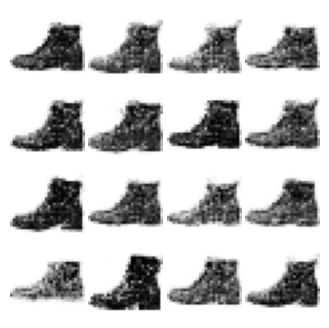

In [ ]:
create("ankle boot")